# Sub-exponential distributions

Fitting data to known distributions use is done using [Chi2Fit](https://hex.pm/packages/chi2fit).

This notebook is a companion to Appendix C of [5] (Second edition of the Kanban Maturity Model).

## Set-up

In [22]:
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Matrix, as: M
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P
alias Exboost.Math

Exboost.Math

### Global parameters

In [23]:
# The size of the backlog, e.g. 50 backlog items
size = 50

# Number of iterations to use in the Monte Carlo
iterations = 1000

# Number of bootstraps to use
bootstraps = 100

# The size of bins for grouping the data
binsize = 4

# Number of probes to use in the chi2 fit
probes = 10_000

# The range of the parameter to look for a (global) minimum
initial = [{0.5,10},{0.5,10}]

[{0.5, 10}, {0.5, 10}]

In [34]:
Code.compiler_options(ignore_module_conflict: true)
defmodule Current do
  def random_fun1(model), do: fn _ -> Distribution.random(model) end
  def random_fun0(model), do: fn -> Distribution.random(model) end
  def ones_fun, do: fn -> 1 end
end
alias Current, as: C

Current

## Sub-exponential: how bad is the mean?

See [5] page 399 figure C.16. We start with a sub-exponential Weibull distribution with kappa=0.8.

In [25]:
kappa = 0.8

0.8

In [26]:
lambda = 20.0
f = D.model "weibull", pars: [kappa,lambda]

#Weibull<"alpha=0.8, beta=20.0">

In [27]:
IO.puts "Average\t\t= #{lambda*Math.tgamma(1+1/kappa)}"
IO.puts "sqrt(Var)\t= #{lambda*:math.sqrt(Math.tgamma(1+2/kappa)-:math.pow(Math.tgamma(1+1/kappa),2))}"

Average		= 22.660061926386923
sqrt(Var)	= 28.563297808051622


:ok

Such a distribution typically looks like:

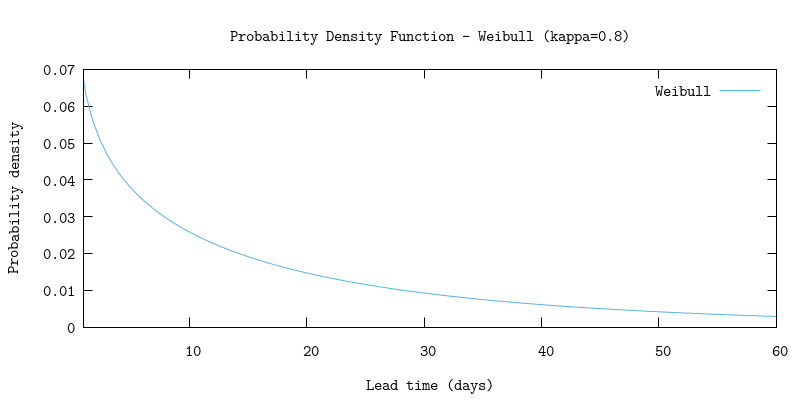

In [28]:
Gnuplot.plot([
    ~w(set terminal pngcairo size 800,400)a,
    ~w(set output)a,
    ~w|set xlabel "Lead\u00a0time\u00a0(days)"|a,
    ~w(set ylabel rotate by 90 "Probability\u00a0density")a,
    ~w(set title 'Probability\u00a0Density\u00a0Function\u00a0-\u00a0Weibull\u00a0(kappa=0.8\)')a,
    ~w(set xrange [1:60])a,
    ~w(plot '-' u 1:2 w lines ls 3 title 'Weibull')a
  ],
  [ 1..100 |> Enum.map(& [&1/100*60,Distribution.pdf(f).(&1/100*60)]) ])
Gnuplotlib.capture() |> Base.encode64 |> IO.write
:"this is an inline image"

### Generate sample data
In this section we recreate the information and conclusions from Figure C.16 in [5].

We define a set of sample sizes ranging between 10 en 10000:

In [29]:
sample_sizes = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,1_000,1_500,2_000,2_500,3_000,5_000,10_000]

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 5000, 10000]

For each of the sizes above data samples are generated and calculate how the sample's mean deviates from the known mean calculated directly from the properties of the Weibull distribution.

In [30]:
avg_expected = lambda*Math.tgamma(1+1/kappa)
result = sample_sizes |> Enum.map(fn sample_size ->
  {avg,sd} = U.mc(1000, fn ->
        data = 1..sample_size |> Enum.map(C.random_fun1(f)) |> Enum.map(&(1+trunc(&1)))
        mean = U.moment(data,1)
        abs(mean-avg_expected)/mean
    end)
  [sample_size,avg,sd]
end)
result |> U.as_table({"Sample size","Relative error to the mean","Error in the relative error"})
:"do not show this result in output"

Sample size|Relative error to the mean|Error in the relative error
-----------|--------------------------|---------------------------
10         |0.37516368804705663       |0.4029860269220092         
20         |0.23547983722209745       |0.21764036636984715        
30         |0.1809249764761942        |0.14712102122829354        
40         |0.16110133773943747       |0.12610018886242402        
50         |0.13710434864925433       |0.10978649881837664        
60         |0.12565732429670712       |0.10144270118374962        
70         |0.11894383603683696       |0.09457731808342208        
80         |0.10341673142219757       |0.07866169751917575        
90         |0.10105929357972111       |0.07646968284316252        
100        |0.09981677723211889       |0.07727126515398633        
200        |0.0715543871715893        |0.05294940424758003        
300        |0.05963608003966442       |0.043907662773338          
400        |0.05096630358957595       |0.0362389205091265     

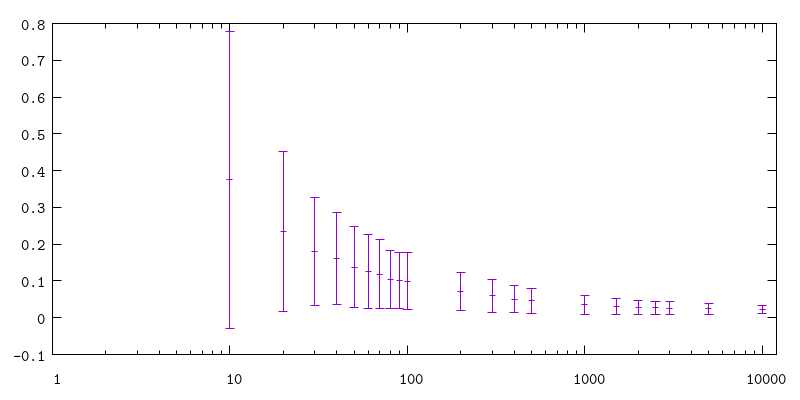

In [31]:
Gnuplot.plot([
    ~w(set terminal pngcairo size 800,400)a,
    ~w(set output)a,
    ~w(set xrange [1:12000])a,
    ~w(set logscale x 10)a,
    ~w(plot '-' u 1:2:3 w yerrorbars notitle)a
  ],
  [result])
Gnuplotlib.capture() |> Base.encode64 |> IO.write
:"this is an inline image"

The graph clearly shows a relative error from the mean less than 10% only when 100 or more data points are used. A relative error less than 5% is achieved for 500 or more data points.

Another thing to notice are the large error bars for small data samples. For a data sample of 10, the relative error from thee real mean can be anything between 0% and 80%!

### Forecast using a dataset

In [47]:
{avg_duration,sd_duration,all} = U.mc(iterations, fn -> U.forecast(C.ones_fun, size, 0, C.random_fun0(f)) end, collect_all?: true)
IO.puts "Average project duration\t= #{avg_duration}"
IO.puts "Relative error\t\t\t= #{sd_duration/avg_duration}"

Average project duration	= 1131.8199464104625
Relative error			= 0.18120108268597426


:ok

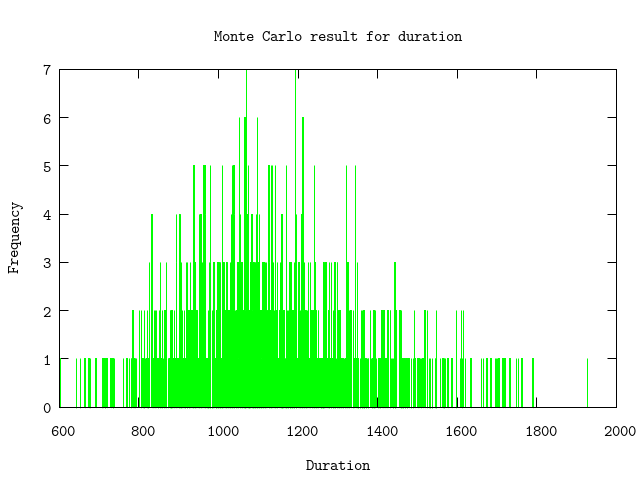

In [48]:
P.histogram(all,
    plottitle: "Monte Carlo result for duration",
    xlabel: "Duration",
    ylabel: "Frequency")
:"this is an inline image"

In [37]:
result = [20,100] |> Enum.map(fn sample_size ->
  {avg,sd} = U.mc(100, fn ->
        data = 1..sample_size |> Enum.map(C.random_fun1(f)) |> Enum.map(&(1+trunc(&1)))
        {mean,_} = U.mc(100, fn -> U.forecast(C.ones_fun, size, 0, fn -> Enum.random(data) end) end)
        abs(mean-avg_duration)/mean
    end)
  [sample_size,avg,sd]
end)
result |> U.as_table({"Sample size","Relative error to the mean","Error in the relative error"})
:"do not show this result in output"

Sample size|Relative error to the mean|Error in the relative error
-----------|--------------------------|---------------------------
20         |0.2771680713586474        |0.27693540777180387        
100        |0.09497716811919446       |0.07890861998904847        


### Forecast based on Weibull fit 

In [38]:
result = [20,100] |> Enum.map(fn sample_size ->
  {avg,sd} = U.mc(100, fn ->
        data = 1..sample_size |> Enum.map(C.random_fun1(f)) |> Enum.map(&(1+trunc(&1)))
        hdata = U.to_bins data, {binsize,0}
        
        model = D.model "weibull"
        
        options = [probes: probes, smoothing: false, model: :linear, saved?: true]
        result = {_,parameters,_,saved} = F.chi2probe hdata, initial, {Distribution.cdf(model), &F.nopenalties/2}, options
        
        options = [{:probes,saved}|options]
        result = {_,cov,parameters,_} = F.chi2fit hdata, {parameters, Distribution.cdf(model), &F.nopenalties/2}, 10, options
        
        fit = D.model "weibull", pars: parameters
        {duration,_} = U.mc(100, fn -> U.forecast(C.ones_fun, size, 0, C.random_fun0(fit)) end)
        abs(duration-avg_duration)/duration
    end)
  [sample_size,avg,sd]
end)
result |> U.as_table({"Sample size","Relative error to the mean","Error in the relative error"})
:"do not show this result in output"

Sample size|Relative error to the mean|Error in the relative error
-----------|--------------------------|---------------------------
20         |0.24231781671335664       |0.18413581199015014        
100        |0.11349572382915736       |0.09842255390485502        


The relative errors seen here are comparable to the errors shown in earlier sections.

## Example: forecast using empirical data (100 data points)

Using the histogram data for the throughput we perform a Monte Carlo simulation to get an estimation for the number of iterations needed to deplete the backlog. Since for a large enough number of samples results of a Monte Carlo simulation approximate the normal distribution. This provides a range for the uncertainty of the number of iterations. We express this as a probability using percentages.

In [42]:
data = 1..100 |> Enum.map(C.random_fun1(f))
{avg,_,all} = U.mc iterations, fn -> U.forecast(C.ones_fun, size, 0, fn -> Enum.random(data) end) end, collect_all?: true
:"do not show this result in output"

The interpretation is that in 50% of the (simulation) runs all items have been completed with 20 iterations. And in 84% of the runs this took 22 iterations. We expect that in 16% of the times it will take more than 22 iterations to complete all items.

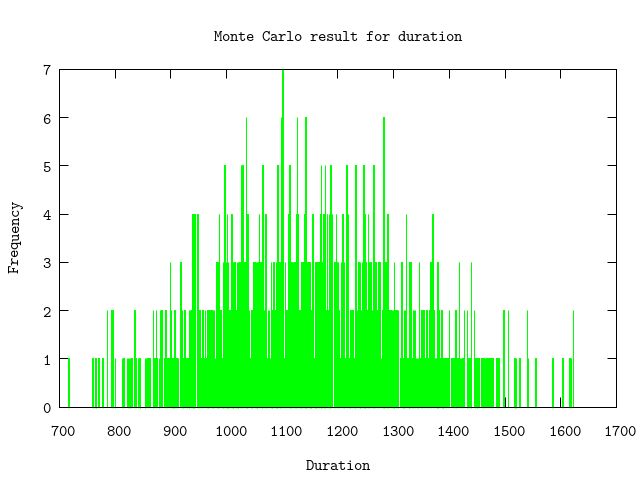

In [43]:
P.histogram(all,
    plottitle: "Monte Carlo result for duration",
    xlabel: "Duration",
    ylabel: "Frequency")
:"this is an inline image"

## References

[1] _Poisson distribution_, https://en.wikipedia.org/wiki/Poisson_distribution/<br>
[2] _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit<br>
[3] _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf<br>
[4] _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf<br>
[5] _Kanban Maturity Model_, David J Andersen & Teodora Bozheva, Edition 1.2